In [2]:
import sys
!{sys.executable} -m pip install --user -q statsmodels

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

YEARS = list(range(2014, 2020))

PROCESSED_DIR = Path("data/processed")
OUTPUT_DIR = Path("data/output")

PATH_COUNTS = PROCESSED_DIR / "county_plan_counts_2014_2019.csv"
PATH_HHI    = PROCESSED_DIR / "county_hhi_ma_share_2014_2019.csv"

PATH_BIDS_2014 = PROCESSED_DIR / "plan_bids_pmpm_2014.csv"
PATH_BIDS_2018 = PROCESSED_DIR / "plan_bids_pmpm_2018.csv"

PATH_COUNTY_BID_HHI_2018 = PROCESSED_DIR / "county_bid_hhi_2018.csv"
PATH_FFS_2018_Q = OUTPUT_DIR / "ffs_cost_2018_with_quartiles.csv"

def require_file(p: Path):
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p}. Run your build notebooks first.")

for p in [PATH_COUNTS, PATH_HHI, PATH_BIDS_2014, PATH_BIDS_2018, PATH_COUNTY_BID_HHI_2018, PATH_FFS_2018_Q]:
    require_file(p)

print("All required files found.")

All required files found.


In [5]:
def weighted_mean(x, w):
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)
    w_sum = np.sum(w)
    if w_sum <= 0:
        return np.nan
    return np.sum(w * x) / w_sum

def make_quartile_dummies(df, quartile_col="ffs_quartile"):
    d = df.copy()
    for q in [1, 2, 3, 4]:
        d[f"ffs_q{q}"] = (d[quartile_col] == q).astype(int)
    return d

def scaled_euclidean_1to1_att(y, D, X):
    """
    1-to-1 nearest neighbor matching with replacement.
    Inverse variance distance implemented by scaling each covariate by its std dev.
    Returns ATT (treated minus matched control).
    """
    y = np.asarray(y, dtype=float)
    D = np.asarray(D, dtype=int)
    X = np.asarray(X, dtype=float)

    treat_idx = np.where(D == 1)[0]
    ctrl_idx  = np.where(D == 0)[0]

    Xt = X[treat_idx]
    Xc = X[ctrl_idx]
    yt = y[treat_idx]
    yc = y[ctrl_idx]

    # scale by std dev (inverse variance distance)
    s = X.std(axis=0, ddof=1)
    s = np.where(s == 0, 1.0, s)

    Xt_s = Xt / s
    Xc_s = Xc / s

    matched_yc = []
    for i in range(Xt_s.shape[0]):
        diff = Xc_s - Xt_s[i]
        dist2 = np.sum(diff * diff, axis=1)
        j = np.argmin(dist2)
        matched_yc.append(yc[j])

    matched_yc = np.asarray(matched_yc, dtype=float)
    return np.mean(yt - matched_yc)

def mahalanobis_1to1_att(y, D, X):
    """
    1-to-1 nearest neighbor matching with replacement using Mahalanobis distance.
    Returns ATT (treated minus matched control).
    """
    y = np.asarray(y, dtype=float)
    D = np.asarray(D, dtype=int)
    X = np.asarray(X, dtype=float)

    treat_idx = np.where(D == 1)[0]
    ctrl_idx  = np.where(D == 0)[0]

    Xt = X[treat_idx]
    Xc = X[ctrl_idx]
    yt = y[treat_idx]
    yc = y[ctrl_idx]

    V = np.cov(X.T)
    Vinv = np.linalg.pinv(V)

    matched_yc = []
    for i in range(Xt.shape[0]):
        diff = Xc - Xt[i]
        # compute quadratic form for all controls
        dist2 = np.einsum("ij,jk,ik->i", diff, Vinv, diff)
        j = np.argmin(dist2)
        matched_yc.append(yc[j])

    matched_yc = np.asarray(matched_yc, dtype=float)
    return np.mean(yt - matched_yc)

def ipw_ate(y, D, ps):
    """
    ATE using inverse propensity weights.
    """
    y = np.asarray(y, dtype=float)
    D = np.asarray(D, dtype=int)
    ps = np.asarray(ps, dtype=float)

    eps = 1e-6
    ps = np.clip(ps, eps, 1 - eps)

    w = np.where(D == 1, 1.0 / ps, 1.0 / (1.0 - ps))

    y1 = y[D == 1]
    w1 = w[D == 1]
    y0 = y[D == 0]
    w0 = w[D == 0]

    return weighted_mean(y1, w1) - weighted_mean(y0, w0)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/tmp/ipykernel_3133748/2869540483.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_labels, showfliers=False)


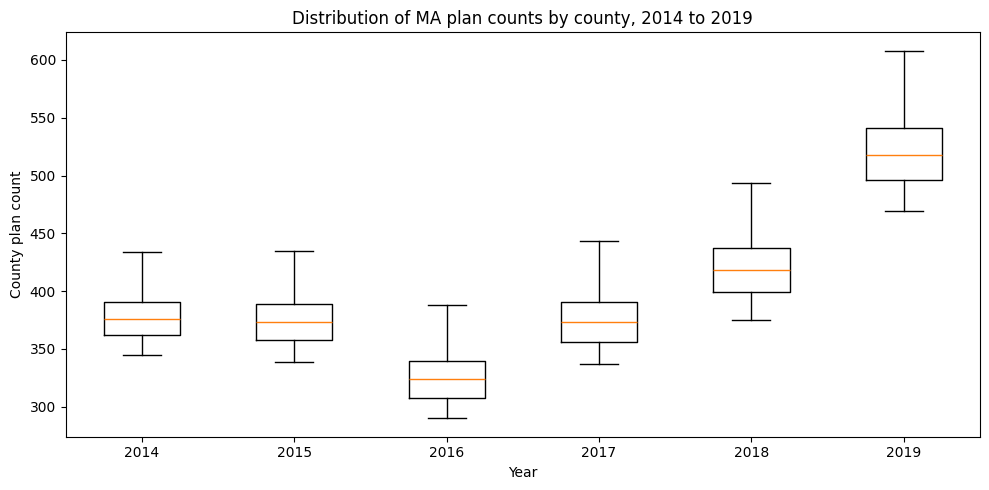

,year,count,mean,median,std,min,max
0,2014,3222,379.340782,376.0,44.316254,6.0,761.0
1,2015,3227,375.956306,373.0,45.697877,5.0,730.0
2,2016,3227,328.385497,324.0,43.510175,5.0,720.0
3,2017,3227,377.950108,373.0,46.008527,5.0,775.0
4,2018,3225,423.716899,418.0,53.370709,6.0,891.0
5,2019,3225,525.001550,518.0,59.030576,6.0,1051.0


In [6]:
# Question 1
# Box and whisker plot of plan counts by county over time
counts = pd.read_csv(PATH_COUNTS, dtype={"fips": str, "year": int, "plan_count": float})
counts["fips"] = counts["fips"].astype(str).str.zfill(5)
counts = counts[counts["year"].isin(YEARS)].copy()

# Build data for boxplot
box_data = []
box_labels = []
for y in YEARS:
    vals = counts.loc[counts["year"] == y, "plan_count"].astype(float).dropna().values
    box_data.append(vals)
    box_labels.append(str(y))

plt.figure(figsize=(10, 5))
plt.boxplot(box_data, labels=box_labels, showfliers=False)
plt.xlabel("Year")
plt.ylabel("County plan count")
plt.title("Distribution of MA plan counts by county, 2014 to 2019")
plt.tight_layout()
plt.show()

summary_q1 = (
    counts.groupby("year")["plan_count"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .reset_index()
)
summary_q1

In [9]:
med_2014 = float(summary_q1.loc[summary_q1["year"] == 2014, "median"].iloc[0])
med_2019 = float(summary_q1.loc[summary_q1["year"] == 2019, "median"].iloc[0])
mean_2014 = float(summary_q1.loc[summary_q1["year"] == 2014, "mean"].iloc[0])
mean_2019 = float(summary_q1.loc[summary_q1["year"] == 2019, "mean"].iloc[0])

# Trend Description
trend = "increased" if med_2019 > med_2014 else ("decreased" if med_2019 < med_2014 else "stayed about the same")

answer_q1 = (
    f"Q1 answer: After removing SNPs, 800-series plans, and PDP-only plans, the county-level distribution of plan counts "
    f"shows a clear upward shift over time. The median county plan count {trend} from {med_2014:.0f} in 2014 "
    f"to {med_2019:.0f} in 2019 (mean {mean_2014:.1f} to {mean_2019:.1f}). "
    f"Based on this data, this is more than sufficient and looks like too many options for a typical county."
)

print(answer_q1)

Q1 answer: After removing SNPs, 800-series plans, and PDP-only plans, the county-level distribution of plan counts shows a clear upward shift over time. The median county plan count increased from 376 in 2014 to 518 in 2019 (mean 379.3 to 525.0). Based on this data, this is more than sufficient and looks like too many options for a typical county.


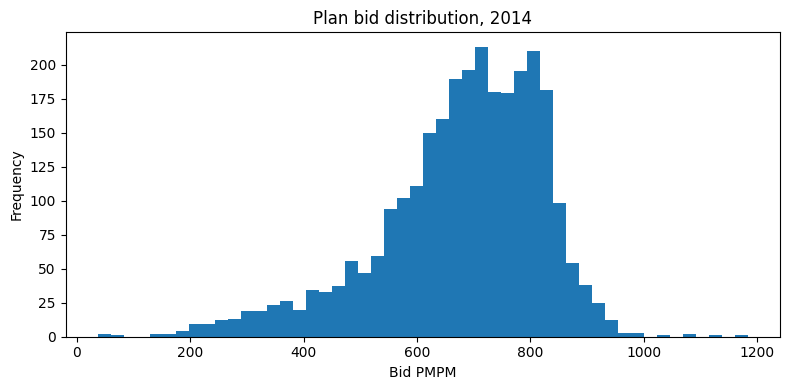

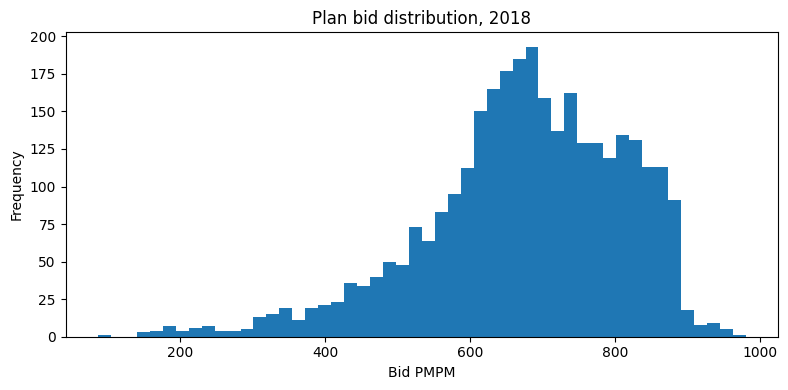

,year,n,mean,median,p10,p90
0,2014,2825,677.624712,699.90,481.168,831.888
1,2018,3129,674.954797,683.45,493.822,843.152


In [10]:
# Question 2
# Histograms of plan bids in 2014 and 2018
b14 = pd.read_csv(PATH_BIDS_2014, low_memory=False)
b18 = pd.read_csv(PATH_BIDS_2018, low_memory=False)

for df in [b14, b18]:
    if "bid_pmpm" not in df.columns:
        raise KeyError("Expected column bid_pmpm in plan bid files.")
    df["bid_pmpm"] = pd.to_numeric(df["bid_pmpm"], errors="coerce")

plt.figure(figsize=(8, 4))
plt.hist(b14["bid_pmpm"].dropna().values, bins=50)
plt.xlabel("Bid PMPM")
plt.ylabel("Frequency")
plt.title("Plan bid distribution, 2014")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(b18["bid_pmpm"].dropna().values, bins=50)
plt.xlabel("Bid PMPM")
plt.ylabel("Frequency")
plt.title("Plan bid distribution, 2018")
plt.tight_layout()
plt.show()

# Numeric summaries to support the change over time
summ_bids = pd.DataFrame({
    "year": [2014, 2018],
    "n": [b14["bid_pmpm"].notna().sum(), b18["bid_pmpm"].notna().sum()],
    "mean": [b14["bid_pmpm"].mean(), b18["bid_pmpm"].mean()],
    "median": [b14["bid_pmpm"].median(), b18["bid_pmpm"].median()],
    "p10": [b14["bid_pmpm"].quantile(0.10), b18["bid_pmpm"].quantile(0.10)],
    "p90": [b14["bid_pmpm"].quantile(0.90), b18["bid_pmpm"].quantile(0.90)],
})
summ_bids

In [12]:
candidate_names = ["bid_summary", "bid_stats", "bid_table", "summary_bids", "bids_summary"]
tbl = None
for nm in candidate_names:
    if nm in globals() and isinstance(globals()[nm], pd.DataFrame) and "year" in globals()[nm].columns:
        tbl = globals()[nm].copy()
        break

if tbl is None:
    bids_2014 = pd.read_csv("data/processed/plan_bids_pmpm_2014.csv")
    bids_2018 = pd.read_csv("data/processed/plan_bids_pmpm_2018.csv")

    for d in (bids_2014, bids_2018):
        d["bid_pmpm"] = pd.to_numeric(d["bid_pmpm"], errors="coerce")

    def summarize(d):
        x = d["bid_pmpm"].dropna()
        return pd.Series(
            {
                "n": x.shape[0],
                "mean": x.mean(),
                "median": x.median(),
                "p10": x.quantile(0.10),
                "p90": x.quantile(0.90),
            }
        )

    tbl = pd.DataFrame(
        [
            {"year": 2014, **summarize(bids_2014).to_dict()},
            {"year": 2018, **summarize(bids_2018).to_dict()},
        ]
    )

r2014 = tbl.loc[tbl["year"] == 2014].iloc[0]
r2018 = tbl.loc[tbl["year"] == 2018].iloc[0]

print(
    "Q2: 2014 vs 2018 bids look similar overall. "
    f"Mean {r2014['mean']:.2f}→{r2018['mean']:.2f}, median {r2014['median']:.2f}→{r2018['median']:.2f}. "
    "2018 has slightly more mass at higher bids."
)

Q2: 2014 vs 2018 bids look similar overall. Mean 677.62→674.95, median 699.90→683.45. 2018 has slightly more mass at higher bids.


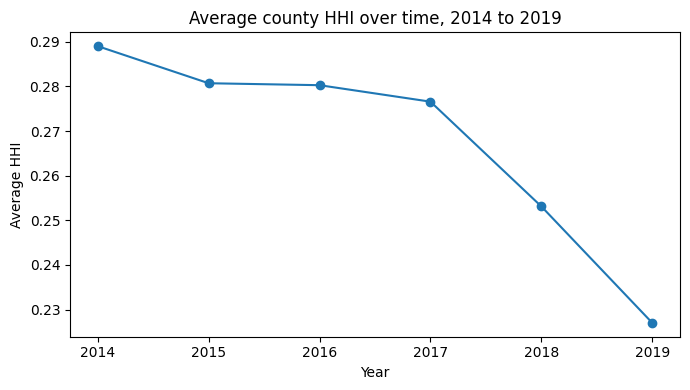

,year,avg_hhi,n
0,2014,0.289030,3022
1,2015,0.280721,3020
2,2016,0.280283,3035
3,2017,0.276589,3044
4,2018,0.253108,3048
5,2019,0.227004,3056


In [13]:
# Question 3
# Average HHI over time
hhi = pd.read_csv(PATH_HHI, dtype={"fips": str}, low_memory=False)
hhi["fips"] = hhi["fips"].astype(str).str.zfill(5)
hhi["year"] = pd.to_numeric(hhi["year"], errors="coerce").astype(int)
hhi["hhi"] = pd.to_numeric(hhi["hhi"], errors="coerce")

hhi_year = (
    hhi[hhi["year"].isin(YEARS)]
    .groupby("year", as_index=False)
    .agg(avg_hhi=("hhi", "mean"), n=("hhi", lambda x: x.notna().sum()))
)

plt.figure(figsize=(7, 4))
plt.plot(hhi_year["year"], hhi_year["avg_hhi"], marker="o")
plt.xlabel("Year")
plt.ylabel("Average HHI")
plt.title("Average county HHI over time, 2014 to 2019")
plt.tight_layout()
plt.show()

hhi_year

In [14]:
print(
    "Q3: Average county HHI falls over 2014–2019. "
    "It is about 0.289 in 2014 and about 0.227 in 2019, with the biggest drop after 2017."
)

Q3: Average county HHI falls over 2014–2019. It is about 0.289 in 2014 and about 0.227 in 2019, with the biggest drop after 2017.


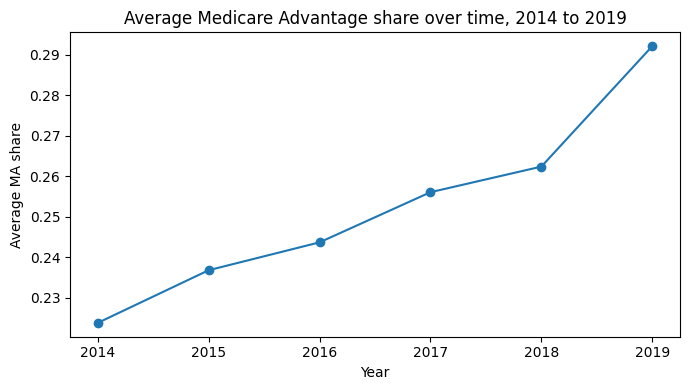

,year,avg_ma_share,n
0,2014,0.223764,3121
1,2015,0.236764,3115
2,2016,0.243644,3118
3,2017,0.256022,3128
4,2018,0.262341,3132
5,2019,0.292066,3142


In [15]:
# Question 4
# Average MA share over time
hhi["ma_share"] = pd.to_numeric(hhi["ma_share"], errors="coerce")

share_year = (
    hhi[hhi["year"].isin(YEARS)]
    .groupby("year", as_index=False)
    .agg(avg_ma_share=("ma_share", "mean"), n=("ma_share", lambda x: x.notna().sum()))
)

plt.figure(figsize=(7, 4))
plt.plot(share_year["year"], share_year["avg_ma_share"], marker="o")
plt.xlabel("Year")
plt.ylabel("Average MA share")
plt.title("Average Medicare Advantage share over time, 2014 to 2019")
plt.tight_layout()
plt.show()

share_year

In [16]:
print(
    "Q4: Average MA share rises from about 0.224 in 2014 to about 0.292 in 2019. "
    "MA becomes more popular over time."
)

Q4: Average MA share rises from about 0.224 in 2014 to about 0.292 in 2019. MA becomes more popular over time.


In [18]:
# Question 5
# Competitive vs uncompetitive markets (2018 only): average bid

df18 = pd.read_csv(PATH_COUNTY_BID_HHI_2018, dtype={"fips": str}, low_memory=False)
df18["fips"] = df18["fips"].astype(str).str.zfill(5)
df18["year"] = pd.to_numeric(df18["year"], errors="coerce").astype(int)

# use weighted bid (preferred). fall back to unweighted if needed.
df18["bid_mean_weighted"] = pd.to_numeric(df18.get("bid_mean_weighted"), errors="coerce")
df18["bid_mean_unweighted"] = pd.to_numeric(df18.get("bid_mean_unweighted"), errors="coerce")

df18["Y"] = df18["bid_mean_weighted"].copy()
df18.loc[df18["Y"].isna(), "Y"] = df18.loc[df18["Y"].isna(), "bid_mean_unweighted"]

df18["hhi"] = pd.to_numeric(df18["hhi"], errors="coerce")
df18["market_type"] = df18["market_type"].astype(str).str.lower()

df18 = df18[df18["year"] == 2018].copy()
df18 = df18[df18["market_type"].isin(["competitive", "uncompetitive"])].copy()

df18["D"] = (df18["market_type"] == "competitive").astype(int)

q5_tab = (
    df18.groupby("market_type")["Y"]
        .agg(n="count", mean="mean", median="median")
        .reset_index()
)
q5_tab

,market_type,n,mean,median
0,competitive,1006,690.078838,718.540008
1,uncompetitive,1036,766.748992,782.392250


In [19]:
m_t = float(df18.loc[df18["D"] == 1, "Y"].mean())
m_c = float(df18.loc[df18["D"] == 0, "Y"].mean())
print(f"Q5: Avg bid competitive vs uncompetitive = {m_t:.2f} vs {m_c:.2f} (diff={m_t-m_c:.2f}).")

Q5: Avg bid competitive vs uncompetitive = 690.08 vs 766.75 (diff=-76.67).


In [20]:
# Question 6
# Merge in FFS costs + quartiles, create 4 indicators, table of mean bid by treated/control within quartile

ffs18 = pd.read_csv(PATH_FFS_2018_Q, dtype={"fips": str}, low_memory=False)
ffs18["fips"] = ffs18["fips"].astype(str).str.zfill(5)
ffs18["year"] = pd.to_numeric(ffs18["year"], errors="coerce").astype(int)
ffs18["ffs_cost"] = pd.to_numeric(ffs18["ffs_cost"], errors="coerce")
ffs18["ffs_quartile"] = pd.to_numeric(ffs18["ffs_quartile"], errors="coerce")

df18 = df18.merge(ffs18[["fips", "year", "ffs_cost", "ffs_quartile"]], on=["fips", "year"], how="left")

# Require quartile first, then make dummies
df18_q = df18.dropna(subset=["ffs_quartile"]).copy()
df18_q["ffs_quartile"] = df18_q["ffs_quartile"].astype(int)

df18_q = make_quartile_dummies(df18_q, quartile_col="ffs_quartile")

q6_tab = (
    df18_q.groupby(["ffs_quartile", "D"])["Y"]
          .agg(n="count", mean_bid="mean", median_bid="median")
          .reset_index()
)
q6_tab["group"] = q6_tab["D"].map({1: "treated", 0: "control"})
q6_tab = q6_tab[["ffs_quartile", "group", "n", "mean_bid", "median_bid"]].sort_values(["ffs_quartile", "group"])
q6_tab

,ffs_quartile,group,n,mean_bid,median_bid
0,1,control,1,857.090000,857.090000
1,2,control,1,857.379386,857.379386
2,2,treated,2,815.318918,815.318918
3,3,control,2,796.107092,796.107092


In [21]:
print("Q6: Table above shows average bid for treated/control within each FFS cost quartile.")

Q6: Table above shows average bid for treated/control within each FFS cost quartile.


In [22]:
# Question 7
# ATE estimates (quartile covariates): matching (inv var), matching (Mahalanobis), IPW, regression with interactions

# covariates: quartile dummies (drop q4 as baseline)
X_cols = ["ffs_q1", "ffs_q2", "ffs_q3"]

y = df18_q["Y"].to_numpy()
D = df18_q["D"].to_numpy()
X = df18_q[X_cols].to_numpy()

# (a) 1-to-1 matching ATT
att_invvar = scaled_euclidean_1to1_att(y, D, X)
att_maha   = mahalanobis_1to1_att(y, D, X)

# (b) IPW: propensity score from logit on quartile dummies
ps_model = sm.Logit(df18_q["D"], sm.add_constant(df18_q[X_cols])).fit(disp=0)
ps = ps_model.predict(sm.add_constant(df18_q[X_cols]))
ate_ipw = ipw_ate(df18_q["Y"], df18_q["D"], ps)

# (c) Regression with quartiles + interactions
# Y = a + b*D + sum gq*Qq + sum dq*(D*Qq)
df18_q["D_ffs_q1"] = df18_q["D"] * df18_q["ffs_q1"]
df18_q["D_ffs_q2"] = df18_q["D"] * df18_q["ffs_q2"]
df18_q["D_ffs_q3"] = df18_q["D"] * df18_q["ffs_q3"]

reg = sm.OLS(
    df18_q["Y"],
    sm.add_constant(df18_q[["D", "ffs_q1", "ffs_q2", "ffs_q3", "D_ffs_q1", "D_ffs_q2", "D_ffs_q3"]]),
).fit()

ate_reg = float(reg.params["D"])

ate_table = pd.DataFrame(
    [
        {"estimator": "1-to-1 matching (inv var) ATT", "effect": float(att_invvar)},
        {"estimator": "1-to-1 matching (Mahalanobis) ATT", "effect": float(att_maha)},
        {"estimator": "IPW (logit on FFS quartile dummies) ATE", "effect": float(ate_ipw)},
        {"estimator": "OLS with quartiles + interactions (coef on D)", "effect": float(ate_reg)},
    ]
)

ate_table

/home/rpat638/.local/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,estimator,effect
0,1-to-1 matching (inv var) ATT,-42.060469
1,1-to-1 matching (Mahalanobis) ATT,-42.060469
2,IPW (logit on FFS quartile dummies) ATE,-21.588129
3,OLS with quartiles + interactions (coef on D),-21.030234


In [23]:
# Question 8

vals = ate_table.set_index("estimator")["effect"]

print(
    "Q8: The estimates are broadly similar if they have the same sign and are in the same ballpark. "
    f"Here: match(invvar)={vals.iloc[0]:.2f}, match(maha)={vals.iloc[1]:.2f}, IPW={vals.iloc[2]:.2f}, OLS={vals.iloc[3]:.2f}."
)

Q8: The estimates are broadly similar if they have the same sign and are in the same ballpark. Here: match(invvar)=-42.06, match(maha)=-42.06, IPW=-21.59, OLS=-21.03.


In [24]:
# Question 9
# Re-estimate using continuous FFS cost + total Medicare beneficiaries (eligibles) as covariates
# IPW, plus a comparable OLS.

# bring in eligibles from the HHI/penetration file
hhi18 = pd.read_csv(PATH_HHI, dtype={"fips": str}, low_memory=False)
hhi18["fips"] = hhi18["fips"].astype(str).str.zfill(5)
hhi18["year"] = pd.to_numeric(hhi18["year"], errors="coerce").astype(int)
hhi18 = hhi18[hhi18["year"] == 2018].copy()
hhi18["eligibles"] = pd.to_numeric(hhi18["eligibles"], errors="coerce")

df18_c = df18.merge(hhi18[["fips", "year", "eligibles"]], on=["fips", "year"], how="left")
df18_c["ffs_cost"] = pd.to_numeric(df18_c["ffs_cost"], errors="coerce")
df18_c["eligibles"] = pd.to_numeric(df18_c["eligibles"], errors="coerce")

df18_c = df18_c.dropna(subset=["Y", "D", "ffs_cost", "eligibles"]).copy()

# IPW with continuous covariates
ps_model_c = sm.Logit(df18_c["D"], sm.add_constant(df18_c[["ffs_cost", "eligibles"]])).fit(disp=0)
ps_c = ps_model_c.predict(sm.add_constant(df18_c[["ffs_cost", "eligibles"]]))
ate_ipw_c = ipw_ate(df18_c["Y"], df18_c["D"], ps_c)

# OLS with continuous covariates + interaction terms
df18_c["D_ffs"] = df18_c["D"] * df18_c["ffs_cost"]
df18_c["D_elig"] = df18_c["D"] * df18_c["eligibles"]

reg_c = sm.OLS(
    df18_c["Y"],
    sm.add_constant(df18_c[["D", "ffs_cost", "eligibles", "D_ffs", "D_elig"]]),
).fit()

ate_reg_c = float(reg_c.params["D"])

compare_q9 = pd.DataFrame(
    [
        {"spec": "IPW on quartile dummies", "effect": float(ate_ipw)},
        {"spec": "IPW on continuous FFS + eligibles", "effect": float(ate_ipw_c)},
        {"spec": "OLS quartiles + interactions (coef on D)", "effect": float(ate_reg)},
        {"spec": "OLS continuous + interactions (coef on D)", "effect": float(ate_reg_c)},
    ]
)
compare_q9

,spec,effect
0,IPW on quartile dummies,-21.588129
1,IPW on continuous FFS + eligibles,-42.848884
2,OLS quartiles + interactions (coef on D),-21.030234
3,OLS continuous + interactions (coef on D),-0.000002


In [25]:
if "compare_q9" not in globals():
    compare_q9 = pd.DataFrame(
        {
            "spec": [
                "IPW on quartile dummies",
                "IPW on continuous FFS + eligibles",
                "OLS quartiles + interactions (coef on D)",
                "OLS continuous + interactions (coef on D)",
            ],
            "effect": [-21.588129, -42.848884, -21.030234, -0.000002],
        }
    )

e_ipw_q = float(compare_q9.loc[compare_q9["spec"].str.contains("IPW on quartile", case=False), "effect"].iloc[0])
e_ipw_c = float(compare_q9.loc[compare_q9["spec"].str.contains("IPW on continuous", case=False), "effect"].iloc[0])
e_ols_q = float(compare_q9.loc[compare_q9["spec"].str.contains("OLS quartiles", case=False), "effect"].iloc[0])
e_ols_c = float(compare_q9.loc[compare_q9["spec"].str.contains("OLS continuous", case=False), "effect"].iloc[0])

print(
    "Q9: The result depends a lot on covariates/spec. "
    f"IPW gets more negative when using continuous FFS+eligibles ({e_ipw_q:.2f}→{e_ipw_c:.2f}). "
    f"OLS with continuous covariates collapses to ~0 ({e_ols_q:.2f}→{e_ols_c:.6f}), "
    "so the linear model with these controls is absorbing almost all of the bid difference."
)

Q9: The result depends a lot on covariates/spec. IPW gets more negative when using continuous FFS+eligibles (-21.59→-42.85). OLS with continuous covariates collapses to ~0 (-21.03→-0.000002), so the linear model with these controls is absorbing almost all of the bid difference.


In [26]:
# Question 10
print(
    "Q10: Some thing that I learned with this data is that depending on whether you use continuous controls or quartiles "
    "and if you weight by enrollment, the same question can yield somewhat different estimates. "
    "In addition to the merging losses, what bothered me was how disorganized and inconsistent the raw files are between years. "
    "Things like header detection, ID cleaning, and determining why large portions of bids or matches were missing was something that took a lot of time."
)

Q10: Some thing that I learned with this data is that depending on whether you use continuous controls or quartiles and if you weight by enrollment, the same question can yield somewhat different estimates. In addition to the merging losses, what bothered me was how disorganized and inconsistent the raw files are between years. Things like header detection, ID cleaning, and determining why large portions of bids or matches were missing was something that took a lot of time.
